# Dimensionality reduction
This notebook implements the dimensionality reduction of the TS data using UMAP in a scriptwise manner.

In [14]:
import pandas as pd
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import umap
from matplotlib.colors import TABLEAU_COLORS
import matplotlib.markers as markers
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

# Get all the available marker shapes
MARKER_SHAPES = list(markers.MarkerStyle.markers.keys())[2:37]
# _ = MARKER_SHAPES.pop(1)

N_CLUSTERS = 5

In [15]:
CLUSTER_COLORS = {cluster_id:color for cluster_id, color in zip(range(len(TABLEAU_COLORS)), TABLEAU_COLORS.values())}
CLUSTER_POINT_SHAPE = {cluster_id:shape for cluster_id, shape in zip(range(len(MARKER_SHAPES)), MARKER_SHAPES)}

In [16]:
def plot_cluster_hulls(points, cluster_labels, error_score):
    fig, ax = plt.subplots(figsize=(20,10))
    legend_elements = []

    for cluster_id in range(N_CLUSTERS):
        cluster_points = points[cluster_labels==cluster_id,:]
        hull = ConvexHull(cluster_points)
        cluster_errors = error_score[cluster_labels==cluster_id]
        sns.scatterplot(x=cluster_points[:,0], y=cluster_points[:,1], hue=cluster_errors, palette='magma', legend=False, marker=CLUSTER_POINT_SHAPE[cluster_id])
        for simplex in hull.simplices:
            plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], c=CLUSTER_COLORS[cluster_id])
            
        plt.fill(cluster_points[hull.vertices,0], cluster_points[hull.vertices,1], alpha=0.1, c=CLUSTER_COLORS[cluster_id])
        plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

        #Add legend information
        legend_elements.append(Line2D([0], [0], marker=CLUSTER_POINT_SHAPE[cluster_id], color=CLUSTER_COLORS[cluster_id], label=f'Cluster {cluster_id+1}',
                          markerfacecolor=CLUSTER_COLORS[cluster_id], markersize=10, linestyle='None'),)
    
    # Add color bar
    sm = plt.cm.ScalarMappable(cmap='magma', norm=plt.Normalize(vmin=min(error_score), vmax=max(error_score)))
    sm._A = []
    ticks = np.linspace(error_score.min(), error_score.max(), 5, endpoint=True)
    plt.colorbar(sm, label='RMSE', ticks=ticks, orientation='vertical', ax=ax)

    #Add legend
    ax.legend(handles=legend_elements, loc='upper right')


### Weather

#### UMAP

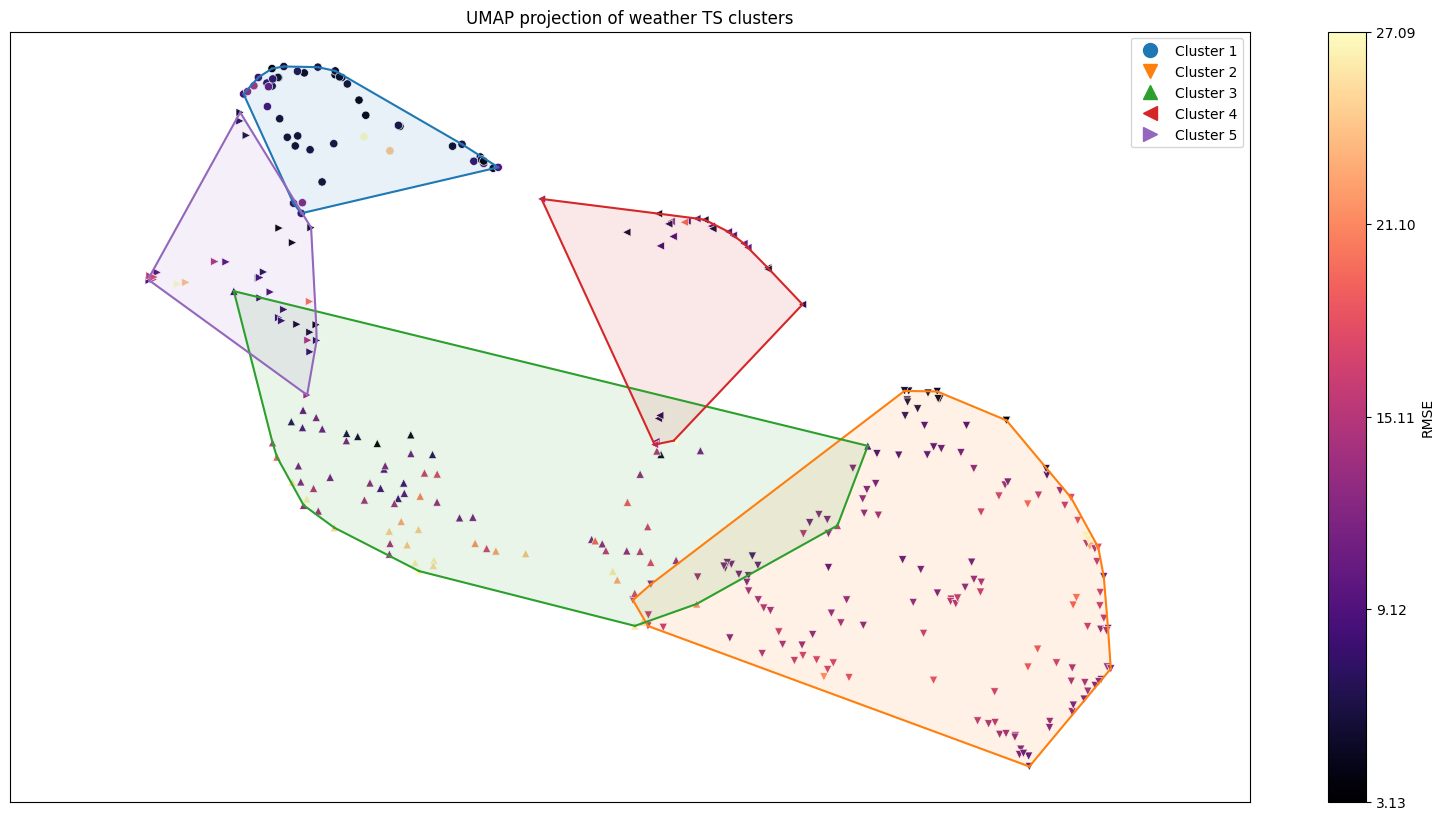

In [22]:
X_weather = pd.read_pickle('../Dataset/preprocessed/weather/X.pkl')
weather_error = pd.read_pickle('../Dataset/performance_scores/error_weather.pkl')
rmse_weather = weather_error.mean(axis=1).values
reducer = umap.UMAP()
scaled_weather_data = StandardScaler().fit_transform(X_weather)
umap_embedding = reducer.fit_transform(scaled_weather_data)
weather_clusters = pd.read_pickle('../Dataset/cluster_data/ts_weather_clusters.pkl').values
plot_cluster_hulls(umap_embedding, weather_clusters, rmse_weather)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of weather TS clusters')
plt.show()

#### PCA

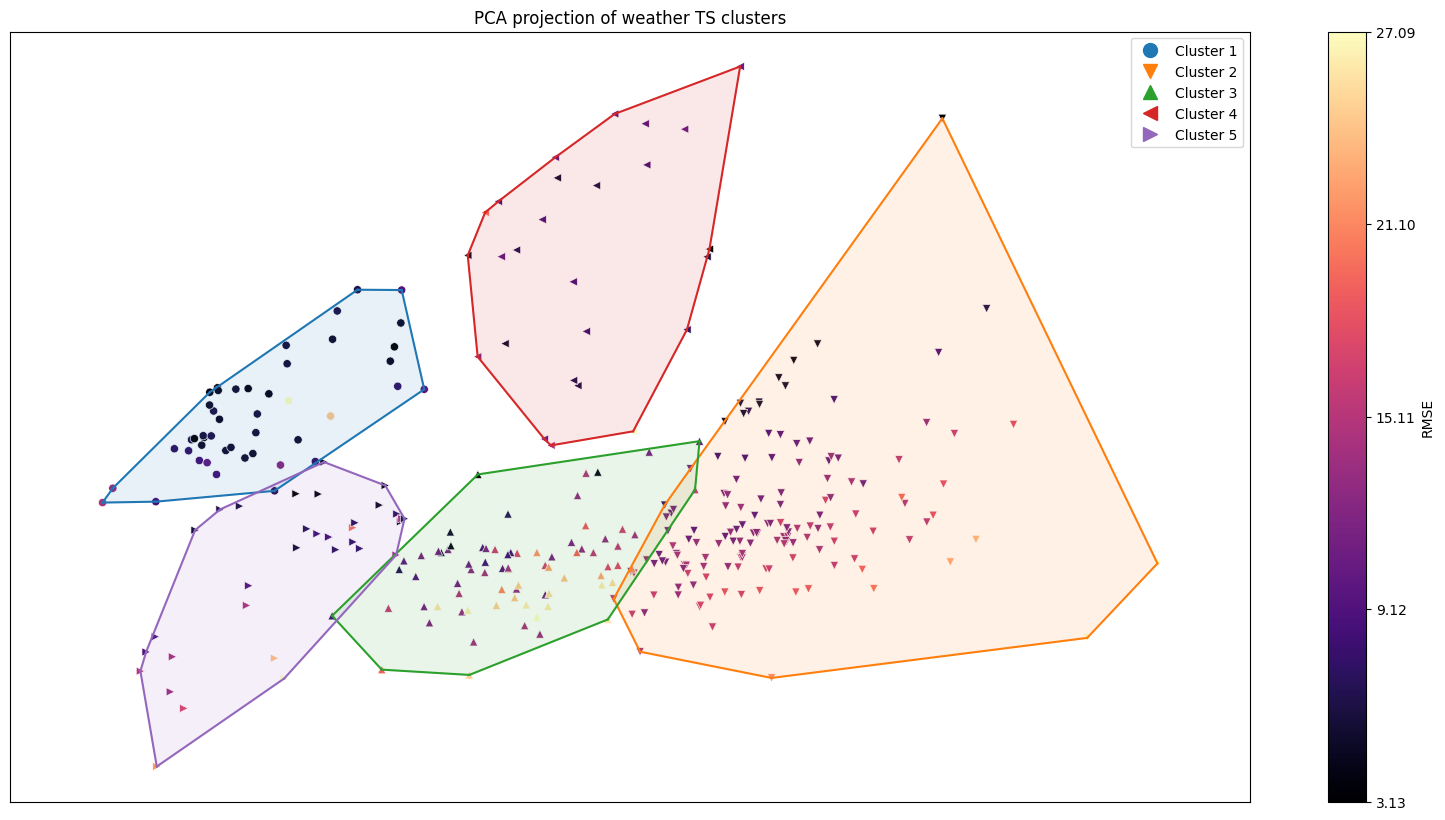

In [23]:
X_weather = pd.read_pickle('../Dataset/preprocessed/weather/X.pkl')
weather_error = pd.read_pickle('../Dataset/performance_scores/error_weather.pkl')
rmse_weather = weather_error.mean(axis=1).values
# define pipeline steps
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('dim_reduction', PCA(n_components=2))
])

pca_embedding =  pca_pipeline.fit_transform(X_weather)
weather_clusters = pd.read_pickle('../Dataset/cluster_data/ts_weather_clusters.pkl').values
plot_cluster_hulls(pca_embedding, weather_clusters, rmse_weather)
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA projection of weather TS clusters')
plt.show()

#### t-SNE

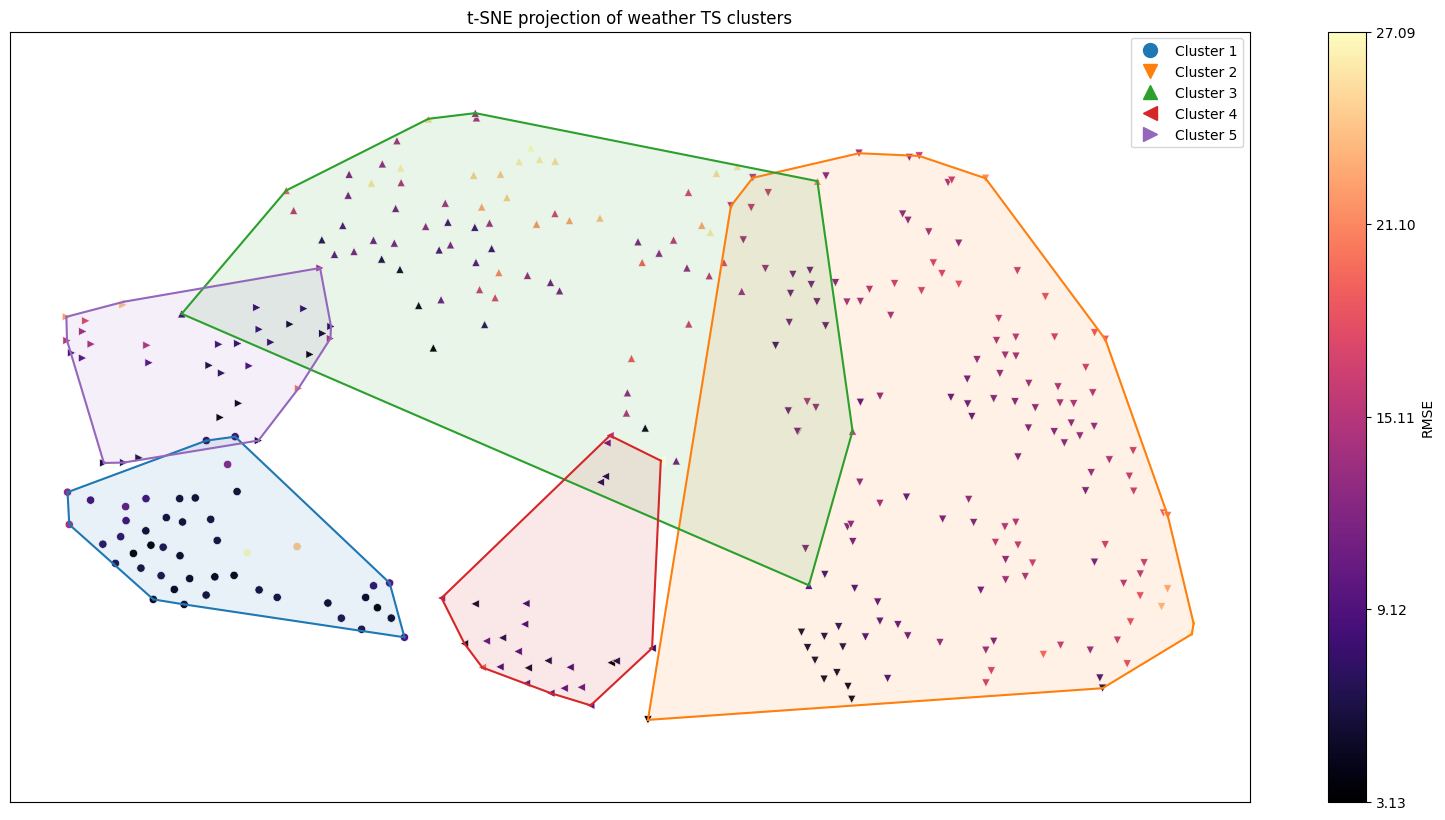

In [24]:
X_weather = pd.read_pickle('../Dataset/preprocessed/weather/X.pkl')
weather_error = pd.read_pickle('../Dataset/performance_scores/error_weather.pkl')
rmse_weather = weather_error.mean(axis=1).values

# define pipeline steps
tsne_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('2d_reduction',  TSNE(n_components=2, random_state=42))
])

tsne_embedding =  tsne_pipeline.fit_transform(X_weather)
weather_clusters = pd.read_pickle('../Dataset/cluster_data/ts_weather_clusters.pkl').values
plot_cluster_hulls(tsne_embedding, weather_clusters, rmse_weather)
plt.gca().set_aspect('equal', 'datalim')
plt.title('t-SNE projection of weather TS clusters')
plt.show()

### Autoencoder

11/11 [==============================] - 0s 2ms/step


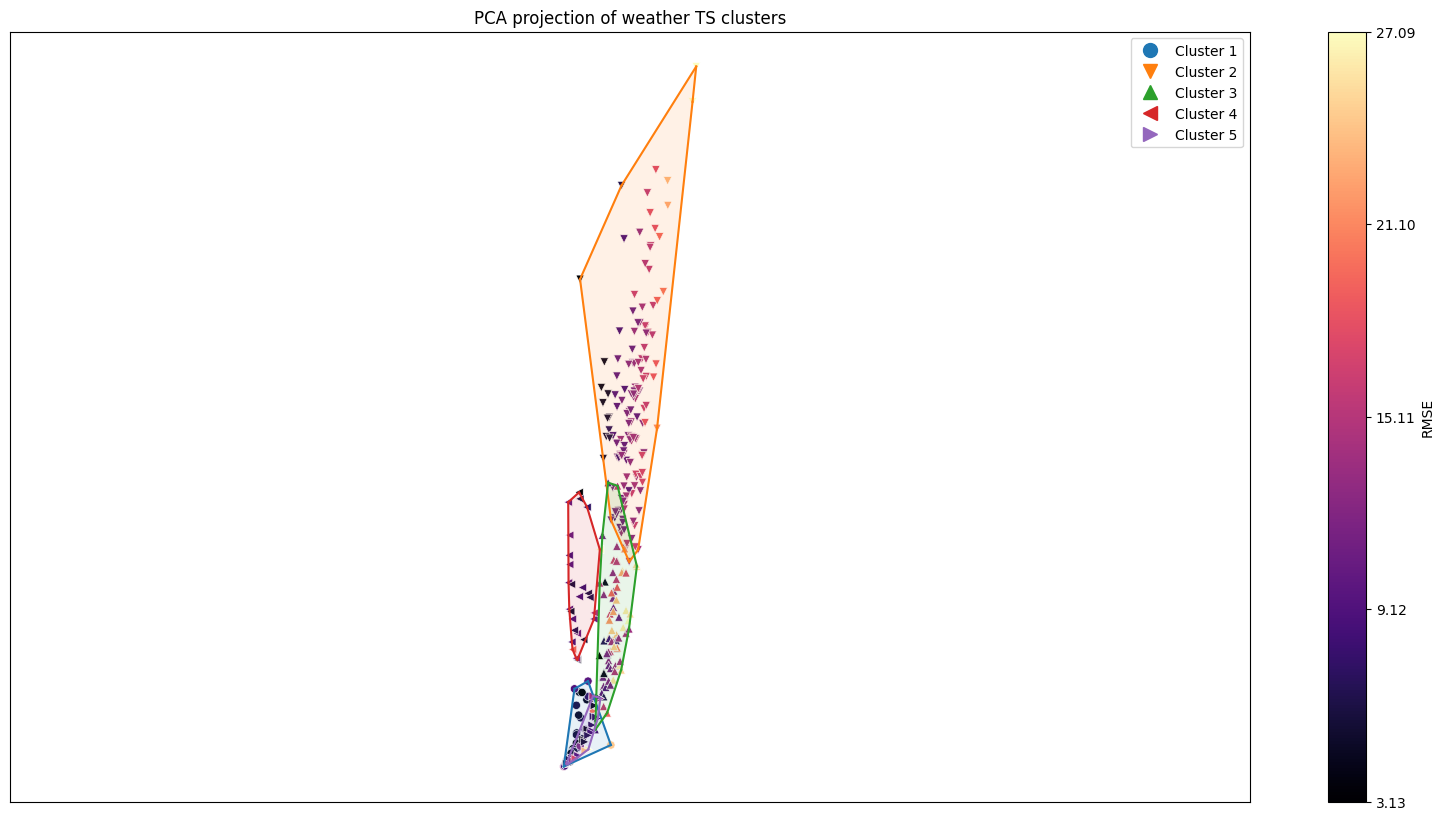

In [44]:
# X_weather = pd.read_pickle('../Dataset/preprocessed/weather/X.pkl')
# weather_error = pd.read_pickle('../Dataset/performance_scores/error_weather.pkl')
# rmse_weather = weather_error.mean(axis=1).values

# scaler = StandardScaler()
# scaled_weather = scaler.fit_transform(X_weather)

# # Define the LSTM autoencoder model
# model = Sequential([
#     # Encoder
#     LSTM(2, activation='relu', input_shape=(X_weather.shape[-1],1)),
#     RepeatVector(X_weather.shape[-1]),
#     # Decoder
#     LSTM(100, activation='relu', return_sequences=True),
#     TimeDistributed(Dense(1))
# ])

# # Compile the model
# model.compile(optimizer=Adam(), loss='mse')
# # Fit the model
# model.fit(scaled_weather, scaled_weather, epochs=150, verbose=0)
# # Create an encoder model
# encoder = Model(inputs=model.inputs, outputs=model.layers[0].output)
# # Use the encoder to create a 2D representation of your time series
# auto_embedding = encoder.predict(scaled_weather)

# weather_clusters = pd.read_pickle('../Dataset/cluster_data/ts_weather_clusters.pkl').values
# plot_cluster_hulls(auto_embedding, weather_clusters, rmse_weather)
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('PCA projection of weather TS clusters')
# plt.show()

#### Compare the three methods by calculating the silhouette score

In [39]:
from sklearn.metrics import silhouette_score

umap_score = silhouette_score(umap_embedding, weather_clusters, metric='euclidean')
pca_score = silhouette_score(pca_embedding, weather_clusters, metric='euclidean')
tsne_score = silhouette_score(tsne_embedding, weather_clusters, metric='euclidean')
auto_score = silhouette_score(auto_embedding, weather_clusters, metric='euclidean')

In [40]:
print(f"Silouhette scores per dimensionality reduction method.")
print(f"     - UMAP: {umap_score}")
print(f"     - PCA: {pca_score}")
print(f"     - t-SNE: {tsne_score}")
print(f"     - Autoencoder: {tsne_score}")

Silouhette scores per dimensionality reduction method.
     - UMAP: 0.43040451407432556
     - PCA: 0.40957033655621516
     - t-SNE: 0.3833127021789551
     - Autoencoder: 0.3833127021789551


In [23]:
class DRTypes:
    PCA = "PCA"
    TSNE = "t-SNE"
    UMAP = "UMAP"


dr_embeddings = {
    DRTypes.PCA: (pca_embedding, pca_score),
    DRTypes.TSNE: (tsne_embedding, tsne_score),
    DRTypes.UMAP: (umap_embedding, umap_score),
}
embedding_info = [(method_name, embeddings, score) for method_name, (embeddings, score) in dr_embeddings.items()]
embedding_info.sort(key=lambda x: x[2], reverse=True)

### Finance

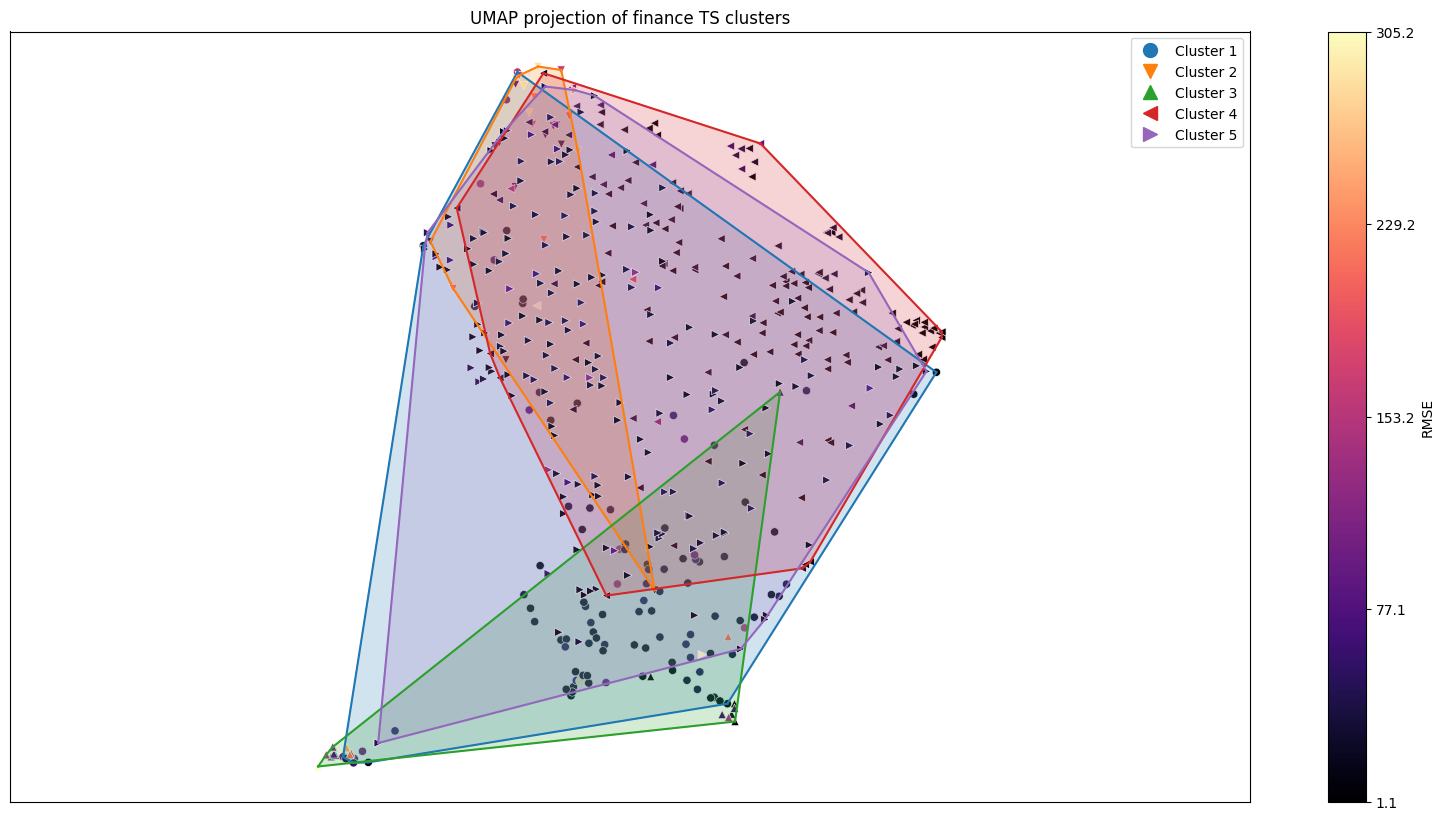

In [ ]:
X_finance = pd.read_pickle('../Dataset/preprocessed/finance/X.pkl')
finance_error = pd.read_pickle('../Dataset/performance_scores/error_finance.pkl')
rmse_finance = finance_error.mean(axis=1).values
reducer = umap.UMAP()
scaled_finance_data = StandardScaler().fit_transform(X_finance)
embedding_finance = reducer.fit_transform(scaled_finance_data)
finance_clusters = pd.read_pickle('ts_finance_clusters.pkl').values
plot_cluster_hulls(embedding_finance, finance_clusters, rmse_finance)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of finance TS clusters')
plt.show()

## Test Autoencoder

In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

# Create some random time series data
n_series = 100
n_timesteps = 50
n_features = 10
data = np.random.randn(n_series, n_timesteps, n_features)

# Define the LSTM autoencoder model
model = Sequential([
    # Encoder
    LSTM(2, activation='relu', input_shape=(n_timesteps,n_features)),
    RepeatVector(n_timesteps),
    # Decoder
    LSTM(100, activation='relu', return_sequences=True),
    TimeDistributed(Dense(n_features))
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Fit the model
model.fit(data, data, epochs=10, verbose=0)

In [5]:
from tensorflow.keras.models import Model

# Create an encoder model
encoder = Model(inputs=model.inputs, outputs=model.layers[0].output)

# Use the encoder to create a 2D representation of your time series
encoded_data = encoder.predict(data)

4/4 [==============================] - 0s 3ms/step
